In [1]:
from fastai.vision import *

In [2]:
path = Config.data_path()/'planet'

In [3]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=0.5, max_warp=0.)

In [5]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [6]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

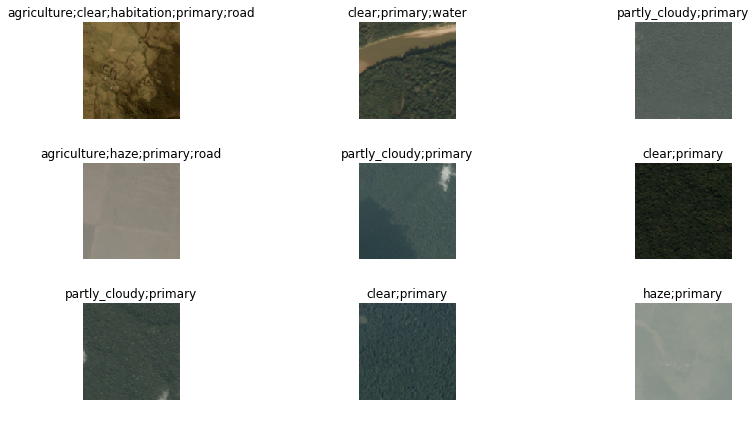

In [7]:
data.show_batch(rows=3, figsize=(12, 6))

In [8]:
arch = models.resnet50

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)

In [10]:
acc_02

functools.partial(<function accuracy_thresh at 0x7fe9eac89f28>, thresh=0.2)

In [11]:
fbeta = partial(accuracy_thresh, thresh=0.2)

In [13]:
learn = cnn_learner(data, arch, metrics=[acc_02, fbeta])

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


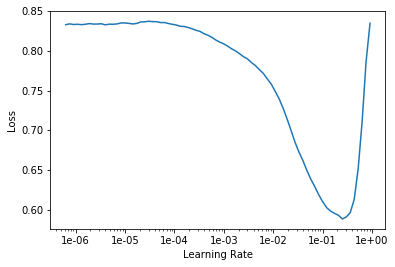

In [15]:
learn.recorder.plot()

In [16]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

In [17]:
learn.export()

In [18]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}

100%|███████████████████████████████████████▊| 601M/603M [00:10<00:00, 43.9MB/s]
100%|████████████████████████████████████████| 603M/603M [00:10<00:00, 61.2MB/s]


In [19]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [20]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path} 

 95%|██████████████████████████████████████  | 289M/304M [00:07<00:00, 50.5MB/s]
100%|████████████████████████████████████████| 304M/304M [00:07<00:00, 43.1MB/s]


In [21]:
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [22]:
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [23]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/planet/test-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/__MACOSX'),
 PosixPath('/home/jupyter/.fastai/data/planet/export.pkl'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional'),
 PosixPath('/home/jupyter/.fastai/data/planet/models'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv.zip')]

In [25]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-additional-jpg'))

In [27]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [28]:
preds[:10]

tensor([[3.6433e-01, 5.4111e-04, 9.4336e-03, 1.8458e-03, 2.7658e-03, 5.9213e-03,
         3.1998e-03, 4.3903e-04, 2.3768e-01, 1.2481e-02, 2.1249e-03, 9.8590e-01,
         9.9498e-01, 1.5461e-01, 4.7354e-03, 5.0936e-03, 4.2107e-01],
        [1.5216e-02, 4.0875e-07, 1.2735e-04, 7.9335e-05, 8.6187e-08, 9.9954e-01,
         3.3406e-06, 5.4685e-07, 5.4009e-03, 6.3434e-04, 2.7527e-05, 2.0527e-04,
         9.9998e-01, 1.4233e-02, 2.3017e-05, 2.9194e-06, 9.9227e-01],
        [1.0402e-03, 8.9735e-07, 7.1484e-06, 1.0549e-04, 8.0778e-06, 4.2541e-03,
         9.8973e-01, 5.9026e-06, 1.2791e-04, 1.3206e-04, 1.6886e-03, 1.9668e-03,
         1.1175e-02, 7.8061e-05, 3.3923e-06, 2.4179e-06, 3.1704e-03],
        [3.5441e-01, 2.9970e-05, 1.4483e-02, 1.4469e-03, 1.6195e-02, 9.9131e-01,
         3.2554e-04, 6.6024e-06, 4.1653e-02, 5.1516e-03, 9.7825e-03, 1.5447e-03,
         9.9515e-01, 1.0992e-02, 1.3458e-03, 9.5424e-04, 7.5138e-03],
        [1.1328e-02, 2.0792e-05, 3.1497e-04, 3.0442e-02, 2.6980e-03, 3.1

In [29]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [30]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary water',
 'clear primary water',
 'cloudy',
 'agriculture clear primary',
 'clear partly_cloudy primary']